**-Sugeno VDA-**

1. Cargar el conjunto de datos de alguna de las señales de VDA que se ofrecen a continuación y graficarlo.

2. Entrenar diferentes modelos de Sugeno con todos ellos, variando la cantidad de reglas R (O el parámetro de radio de vecindad del clustering sustractivo, si corresponde). Graficar el error cuadrático medio (MSE) vs. R.

3. Elegir uno de los modelos según la mejor relación entre R y el MSE obtenido.

4. Sobremuestrear la señal, barriendo la variable de entrada para tener muchos más valores de muestras que con los datos originales y utilizando el modelo de Sugeno seleccionado.

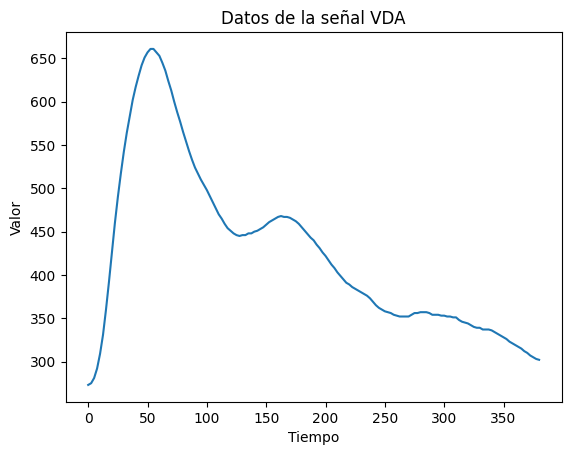

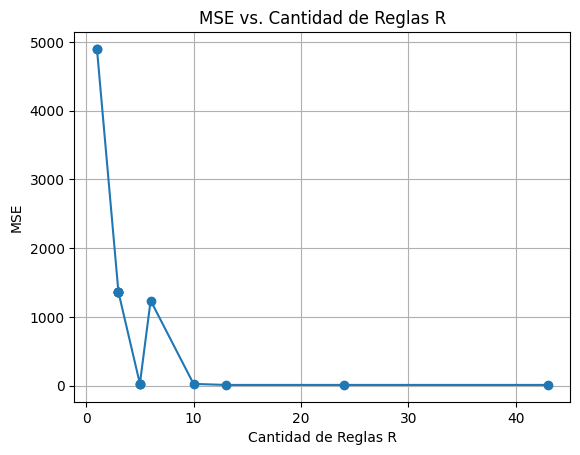

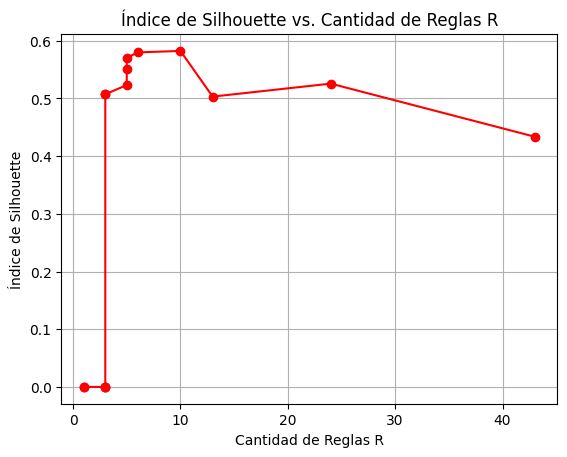

Mejor indice: 11
Mejor radio: 0.4


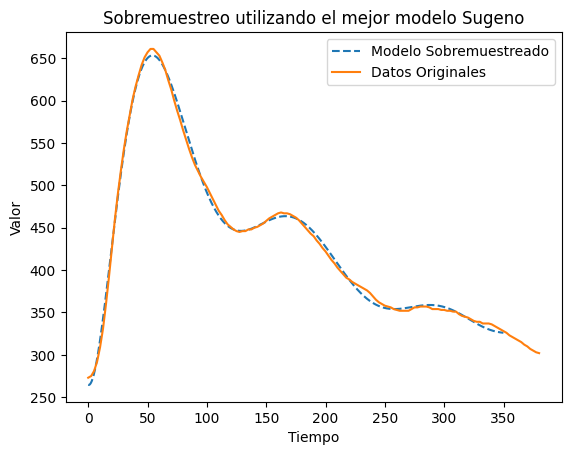

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance_matrix
from sklearn.metrics import silhouette_score

# Definición de subclustering sustractivo
def subclust2(data, Ra, Rb=0, AcceptRatio=0.3, RejectRatio=0.1):
    if Rb == 0:
        Rb = Ra * 1.15

    scaler = MinMaxScaler()
    scaler.fit(data)
    ndata = scaler.transform(data)

    P = distance_matrix(ndata, ndata)
    alpha = (Ra / 2) ** 2
    P = np.sum(np.exp(-P ** 2 / alpha), axis=0)

    centers = []
    i = np.argmax(P)
    C = ndata[i]
    p = P[i]
    centers = [C]

    continuar = True
    restarP = True
    while continuar:
        pAnt = p
        if restarP:
            P = P - p * np.array([np.exp(-np.linalg.norm(v - C) ** 2 / (Rb / 2) ** 2) for v in ndata])
        restarP = True
        i = np.argmax(P)
        C = ndata[i]
        p = P[i]
        if p > AcceptRatio * pAnt:
            centers = np.vstack((centers, C))
        elif p < RejectRatio * pAnt:
            continuar = False
        else:
            dr = np.min([np.linalg.norm(v - C) for v in centers])
            if dr / Ra + p / pAnt >= 1:
                centers = np.vstack((centers, C))
            else:
                P[i] = 0
                restarP = False
        if not any(v > 0 for v in P):
            continuar = False
    distancias = [[np.linalg.norm(p - c) for p in ndata] for c in centers]
    labels = np.argmin(distancias, axis=0)
    centers = scaler.inverse_transform(centers)
    return labels, centers

def gaussmf(data, mean, sigma):
    return np.exp(-((data - mean) ** 2.) / (2 * sigma ** 2.))

class fisInput:
    def __init__(self, min, max, centroids):
        self.minValue = min
        self.maxValue = max
        self.centroids = centroids

    def view(self):
        x = np.linspace(self.minValue, self.maxValue, 20)
        plt.figure()
        for m in self.centroids:
            s = (self.minValue - self.maxValue) / 8 ** 0.5
            y = gaussmf(x, m, s)
            plt.plot(x, y)

class fis:
    def __init__(self):
        self.rules = []
        self.inputs = []

    def genfis(self, data, radii):
        labels, cluster_center = subclust2(data, radii)
        n_clusters = len(cluster_center)

        cluster_center = cluster_center[:, :-1]
        P = data[:, :-1]
        maxValue = np.max(P, axis=0)
        minValue = np.min(P, axis=0)

        self.inputs = [fisInput(maxValue[i], minValue[i], cluster_center[:, i]) for i in range(len(maxValue))]
        self.rules = cluster_center
        self.entrenar(data)

    def entrenar(self, data):
        P = data[:, :-1]
        T = data[:, -1]

        sigma = np.array([(i.maxValue - i.minValue) / np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P, cluster, sigma), axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0, n_vars), len(self.rules))
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]

        A = acti * inp / sumMu
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        self.solutions = solutions
        return 0

    def evalfis(self, data):
        sigma = np.array([(i.maxValue - i.minValue) / np.sqrt(8) for i in self.inputs])
        f = [np.prod(gaussmf(P, cluster, sigma), axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        P = np.c_[P, np.ones(len(P))]
        n_vars = P.shape[1]

        orden = np.tile(np.arange(0, n_vars), len(self.rules))
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]

        A = acti * inp / sumMu
        b = T

        solutions, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
        self.solutions = solutions
        return 0

    def evalfis(self, data):
        sigma = np.array([(input.maxValue - input.minValue) for input in self.inputs]) / np.sqrt(8)
        f = [np.prod(gaussmf(data, cluster, sigma), axis=1) for cluster in self.rules]
        nivel_acti = np.array(f).T
        sumMu = np.vstack(np.sum(nivel_acti, axis=1))

        P = np.c_[data, np.ones(len(data))]

        n_vars = P.shape[1]
        n_clusters = len(self.rules)

        orden = np.tile(np.arange(0, n_vars), n_clusters)
        acti = np.tile(nivel_acti, [1, n_vars])
        inp = P[:, orden]
        coef = self.solutions

        return np.sum(acti * inp * coef / sumMu, axis=1)

    def viewInputs(self):
        for input in self.inputs:
            input.view()

# Cargar los datos de señales VDA
datos = np.loadtxt('samplesVDA3.txt')
y = np.array(datos)
x = []

cont = 0
for i in y:
    x.append(2.5 * cont)
    cont += 1

datos = np.array([x, y]).transpose()
plt.plot(datos[:, 0], datos[:, 1])
plt.title("Datos de la señal VDA")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()

# Graficar el error cuadrático medio (MSE) y el índice de Silhouette vs. cantidad de reglas R
errores = []
reglas = []
silhouettes = []
radios = np.arange(0.1, 1.6, 0.1)

for radio in radios[::-1]:
    fis2 = fis()
    fis2.genfis(datos, radio)

    # Guardar la cantidad de reglas
    reglas.append(len(fis2.rules))

    # Evaluación
    predicciones = fis2.evalfis(datos[:, :-1])

    # Calcular el MSE
    error = datos[:, -1] - predicciones
    mse = np.sum(error ** 2) / len(datos)
    errores.append(mse)

    # Calcular el índice de Silhouette
    labels = subclust2(datos[:, :-1], radio)[0]
    # Only calculate silhouette score if there are more than 1 cluster
    if len(np.unique(labels)) > 1:
        silhouette_avg = silhouette_score(datos[:, :-1], labels)
        silhouettes.append(silhouette_avg)
    else:
        silhouettes.append(0) # Append 0 if only one cluster is found


# Graficar MSE vs. cantidad de reglas
plt.figure()
plt.plot(reglas, errores, marker='o', label='MSE')
plt.xlabel("Cantidad de Reglas R")
plt.ylabel("MSE")
plt.title("MSE vs. Cantidad de Reglas R")
plt.grid(True)
plt.show()

# Graficar el índice de Silhouette vs. cantidad de reglas R
plt.figure()
plt.plot(reglas, silhouettes, marker='o', color='r', label='Índice de Silhouette')
plt.xlabel("Cantidad de Reglas R")
plt.ylabel("Índice de Silhouette")
plt.title("Índice de Silhouette vs. Cantidad de Reglas R")
plt.grid(True)
plt.show()

# Selección del mejor modelo según el índice de Silhouette
mejor_indice = np.argmax(silhouettes)  # El índice máximo del índice de Silhouette
mejor_radio = radios[::-1][mejor_indice]
mejor_modelo = fis()
mejor_modelo.genfis(datos, mejor_radio)

print(f"Mejor indice: {mejor_indice}")
print(f"Mejor radio: {mejor_radio}")
# Sobremuestreo con el mejor modelo
datos_sobremuestreados = np.arange(0, 350, 0.1)
resultados_sobremuestreados = mejor_modelo.evalfis(np.vstack(datos_sobremuestreados))

plt.figure()
plt.plot(datos_sobremuestreados, resultados_sobremuestreados, linestyle='--', label="Modelo Sobremuestreado")
plt.plot(datos[:, 0], datos[:, 1], label="Datos Originales")
plt.legend()
plt.title("Sobremuestreo utilizando el mejor modelo Sugeno")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.show()
